# Machine Learning Model MLP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
import pickle

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings("ignore")
sns.set(rc={'figure.figsize':(15,10)})
warnings.filterwarnings('ignore')

In [2]:
def position_index(x):
    if x<4:
        return 1
    if x>10:
        return 3
    else :
        return 2

In [3]:
def save_obj(obj, name ):
    with open('web/'+ name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Clean Historic and 2022 Data

In [4]:
results = pd.read_csv(r'./data_f1/results.csv')
races = pd.read_csv(r'./data_f1/races.csv')
quali = pd.read_csv(r'./data_f1/qualifying.csv')
drivers = pd.read_csv(r'./data_f1/drivers.csv')
constructors = pd.read_csv(r'./data_f1/constructors.csv')
circuit = pd.read_csv(r'./data_f1/circuits.csv')

In [5]:
df1 = pd.merge(races,results,how='inner',on=['raceId'])
df2 = pd.merge(df1,quali,how='inner',on=['raceId','driverId','constructorId'])
df3 = pd.merge(df2,drivers,how='inner',on=['driverId'])
df4 = pd.merge(df3,constructors,how='inner',on=['constructorId'])
df5 = pd.merge(df4,circuit,how='inner',on=['circuitId'], suffixes=('_a', '_b'))
data = df5

In [6]:
#considering data points from 2010
data = data[data['year']>=2010]

In [7]:
#rename the columns
data.rename(columns={'name':'GP_name','position_y':'position','grid':'quali_pos','name_y':'constructor','nationality_x':'driver_nationality','nationality_y':'constructor_nationality'},inplace=True)
data['driver'] = data['forename']+' '+data['surname']
data['date'] = pd.to_datetime(data['date'])
data['dob'] = pd.to_datetime(data['dob'])

In [8]:
#creating a driver age parameter
data['age_at_gp_in_days'] = abs(data['dob']-data['date'])
data['age_at_gp_in_days'] = data['age_at_gp_in_days'].apply(lambda x: str(x).split(' ')[0])

In [9]:
#Some of the constructors changed their name over the year so replacing old names with current name
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Force India' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Aston Martin' if x=='Racing Point' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alfa Romeo' if x=='Sauber' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Lotus F1' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Renault' else x)
# Correction for 2021
data['constructor'] = data['constructor'].apply(lambda x: 'Alpine F1' if x=='Alpine F1 Team' else x)
data['constructor'] = data['constructor'].apply(lambda x: 'AlphaTauri' if x=='Toro Rosso' else x)

In [10]:
data['driver_nationality'] = data['driver_nationality'].apply(lambda x: str(x)[:3])
data['constructor_nationality'] = data['constructor_nationality'].apply(lambda x: str(x)[:3])
data['country'] = data['country'].apply(lambda x: 'Bri' if x=='UK' else x)
data['country'] = data['country'].apply(lambda x: 'Ame' if x=='USA' else x)
data['country'] = data['country'].apply(lambda x: 'Fre' if x=='Fra' else x)
data['country'] = data['country'].apply(lambda x: str(x)[:3])
data['driver_home'] = data['driver_nationality'] == data['country']
data['constructor_home'] = data['constructor_nationality'] == data['country']
data['driver_home'] = data['driver_home'].apply(lambda x: int(x))
data['constructor_home'] = data['constructor_home'].apply(lambda x: int(x))

In [11]:
#reasons for DNF(did not finish)
data['driver_dnf'] = data['statusId'].apply(lambda x: 1 if x in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137] else 0)
data['constructor_dnf'] = data['statusId'].apply(lambda x: 1 if x not in [3,4,20,29,31,41,68,73,81,97,82,104,107,130,137,1] else 0)
data.drop(['forename','surname'],axis=1,inplace=True)

In [12]:
historicData = data.drop(data[data.year == 2022].index)
data_2022 = data[data.year == 2022]

In [13]:
historicData.to_csv('./data_f1/ANNData/data_filtered.csv', index = False)
data_2022.to_csv('./data_f1/ANNData/data_filtered_2022.csv', index = False)

### Prepare Historic Data

In [14]:
data = pd.read_csv('./data_f1/ANNData/data_filtered.csv')

In [15]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [16]:
driver_confidence_dict_str = {}
for key , value in driver_confidence_dict.items():
    # Correct for New Drivers
    if value == 1.0:
        value = 0.10
    driver_confidence_dict_str[key] = np. array([value])
    print ("%s: %s" % (key, value))

save_obj(driver_confidence_dict_str, 'driver_dict' )

Adrian Sutil: 0.868421052631579
Alexander Albon: 0.972972972972973
Alexander Rossi: 0.1
André Lotterer: 0.1
Antonio Giovinazzi: 0.9180327868852459
Brendon Hartley: 0.88
Bruno Senna: 0.8260869565217391
Carlos Sainz: 0.9142857142857143
Charles Leclerc: 0.8765432098765432
Charles Pic: 0.9487179487179487
Christian Klien: 0.1
Daniel Ricciardo: 0.9521531100478469
Daniil Kvyat: 0.9196428571428571
Esteban Gutiérrez: 0.847457627118644
Esteban Ocon: 0.9431818181818182
Felipe Massa: 0.9161290322580645
Felipe Nasr: 0.925
Fernando Alonso: 0.9333333333333333
George Russell: 0.9166666666666666
Giedo van der Garde: 0.8421052631578947
Heikki Kovalainen: 0.95
Jack Aitken: 0.1
Jaime Alguersuari: 0.9210526315789473
Jarno Trulli: 0.972972972972973
Jean-Éric Vergne: 0.9137931034482758
Jenson Button: 0.9407407407407408
Jolyon Palmer: 0.8571428571428572
Jules Bianchi: 0.9117647058823529
Jérôme d'Ambrosio: 0.95
Kamui Kobayashi: 0.8356164383561644
Karun Chandhok: 0.8181818181818181
Kevin Magnussen: 0.9327731092

In [17]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [19]:
constructor_reliability_dict_str = {}
for key , value in constructor_reliability_dict.items():
    # Correct value 
    constructor_reliability_dict_str[key] = np. array([value])
    print ("%s: %s" % (key, value))
    
save_obj(constructor_reliability_dict_str, 'constructor_dict' )

Alfa Romeo: 0.41276595744680855
AlphaTauri: 0.47558386411889597
Alpine F1: 0.5340425531914894
Aston Martin: 0.6088794926004228
Caterham: 0.1785714285714286
Ferrari: 0.8776371308016877
HRT: 0.15652173913043477
Haas F1 Team: 0.345679012345679
Lotus: 0.07894736842105265
Manor Marussia: 0.12121212121212122
Marussia: 0.16666666666666663
McLaren: 0.6093418259023354
Mercedes: 0.8879492600422833
Red Bull: 0.836864406779661
Virgin: 0.09210526315789469
Williams: 0.4820295983086681


In [91]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])
#removing retired drivers and constructors
active_constructors = constructor_reliability_dict.keys()
active_drivers = driver_confidence.index
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [92]:
cleaned_data = data[['position', 'active_constructor', 'active_driver', 'GP_name','constructor','driver', 'quali_pos', 'positionOrder', 'points', 'constructor_reliability', 'year', 'round', 'driver_confidence', 'number_x', 'lat']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('./data_f1/ANNData/cleaned_data.csv',index=False)

### Prepare 2022 data

In [93]:
data = pd.read_csv('./data_f1/ANNData/data_filtered_2022.csv')

In [94]:
dnf_by_driver = data.groupby('driver').sum()['driver_dnf']
driver_race_entered = data.groupby('driver').count()['driver_dnf']
driver_dnf_ratio = (dnf_by_driver/driver_race_entered)
driver_confidence = 1-driver_dnf_ratio
driver_confidence_dict = dict(zip(driver_confidence.index,driver_confidence))

In [95]:
driver_confidence_dict

{'Alexander Albon': 0.8571428571428572,
 'Carlos Sainz': 0.8181818181818181,
 'Charles Leclerc': 0.9545454545454546,
 'Daniel Ricciardo': 0.9545454545454546,
 'Esteban Ocon': 1.0,
 'Fernando Alonso': 0.9545454545454546,
 'George Russell': 0.9545454545454546,
 'Guanyu Zhou': 0.9090909090909091,
 'Kevin Magnussen': 0.9090909090909091,
 'Lance Stroll': 0.9545454545454546,
 'Lando Norris': 0.9545454545454546,
 'Lewis Hamilton': 0.9545454545454546,
 'Max Verstappen': 1.0,
 'Mick Schumacher': 0.9545454545454546,
 'Nicholas Latifi': 0.8181818181818181,
 'Nico Hülkenberg': 1.0,
 'Nyck de Vries': 1.0,
 'Pierre Gasly': 0.9545454545454546,
 'Sebastian Vettel': 0.9,
 'Sergio Pérez': 0.9545454545454546,
 'Valtteri Bottas': 0.9090909090909091,
 'Yuki Tsunoda': 0.8636363636363636}

In [96]:
dnf_by_constructor = data.groupby('constructor').sum()['constructor_dnf']
constructor_race_entered = data.groupby('constructor').count()['constructor_dnf']
constructor_dnf_ratio = (dnf_by_constructor/constructor_race_entered)
constructor_reliability = 1-constructor_dnf_ratio
constructor_reliability_dict = dict(zip(constructor_reliability.index,constructor_reliability))

In [97]:
constructor_reliability_dict

{'Alfa Romeo': 0.5681818181818181,
 'AlphaTauri': 0.5681818181818181,
 'Alpine F1': 0.6818181818181819,
 'Aston Martin': 0.7045454545454546,
 'Ferrari': 0.9090909090909091,
 'Haas F1 Team': 0.4772727272727273,
 'McLaren': 0.7727272727272727,
 'Mercedes': 0.9318181818181819,
 'Red Bull': 0.9090909090909091,
 'Williams': 0.5454545454545454}

In [98]:
data['driver_confidence'] = data['driver'].apply(lambda x:driver_confidence_dict[x])
data['constructor_reliability'] = data['constructor'].apply(lambda x:constructor_reliability_dict[x])
#removing retired drivers and constructors
active_constructors = constructor_reliability_dict.keys()
active_drivers = driver_confidence.index
data['active_driver'] = data['driver'].apply(lambda x: int(x in active_drivers))
data['active_constructor'] = data['constructor'].apply(lambda x: int(x in active_constructors))

In [99]:
cleaned_data = data[['position', 'active_constructor', 'active_driver', 'GP_name','constructor','driver', 'quali_pos', 'positionOrder', 'points', 'constructor_reliability', 'year', 'round', 'driver_confidence', 'number_x', 'lat']]
cleaned_data = cleaned_data[(cleaned_data['active_driver']==1)&(cleaned_data['active_constructor']==1)]
cleaned_data.to_csv('./data_f1/ANNData/cleaned_data_2022.csv',index=False)

### Analysis F1 Teams and Drivers Probability after last race

In [23]:
## Analysis F1 Teams and Drivers Probability after last race
data2022 = pd.read_csv('./data_f1/ANNData/data_filtered_2022.csv')

In [24]:
data2022=data2022.sort_values(by='date')
races = data2022['GP_name'].unique().tolist()
print(races)

['Bahrain International Circuit', 'Jeddah Corniche Circuit', 'Albert Park Grand Prix Circuit', 'Autodromo Enzo e Dino Ferrari', 'Miami International Autodrome', 'Circuit de Barcelona-Catalunya', 'Circuit de Monaco', 'Baku City Circuit', 'Circuit Gilles Villeneuve', 'Silverstone Circuit', 'Red Bull Ring', 'Circuit Paul Ricard', 'Hungaroring', 'Circuit de Spa-Francorchamps', 'Circuit Park Zandvoort', 'Autodromo Nazionale di Monza', 'Marina Bay Street Circuit', 'Suzuka Circuit', 'Circuit of the Americas', 'Autódromo Hermanos Rodríguez', 'Autódromo José Carlos Pace', 'Yas Marina Circuit']


In [25]:
drivers = data2022['driver'].unique().tolist()
print(drivers)

['Yuki Tsunoda', 'Nicholas Latifi', 'Daniel Ricciardo', 'Lando Norris', 'Carlos Sainz', 'Charles Leclerc', 'Fernando Alonso', 'Esteban Ocon', 'Lewis Hamilton', 'George Russell', 'Sergio Pérez', 'Max Verstappen', 'Nico Hülkenberg', 'Lance Stroll', 'Valtteri Bottas', 'Guanyu Zhou', 'Kevin Magnussen', 'Mick Schumacher', 'Alexander Albon', 'Pierre Gasly', 'Sebastian Vettel', 'Nyck de Vries']


In [26]:
constructors = data2022['constructor'].unique().tolist()
print(constructors)

['AlphaTauri', 'Williams', 'McLaren', 'Ferrari', 'Alpine F1', 'Mercedes', 'Red Bull', 'Aston Martin', 'Alfa Romeo', 'Haas F1 Team']


In [27]:
results = {'race': [],
          'driver':[],
          'constructor':[],
          'points':[]}
for race in races:
    for driver in drivers:
        clst = data2022.loc[(data2022['GP_name']==race)&(data2022['driver']==driver)]['constructor'].unique().tolist()
        plst = data2022.loc[(data2022['GP_name']==race)&(data2022['driver']==driver)]['points'].unique().tolist()
        for c in clst:
            for p in plst:
                results['race'].append(race)
                results['driver'].append(driver)
                results['constructor'].append(c)
                results['points'].append(p)

In [31]:
df2022= pd.DataFrame(results)
print (df2022)

                              race            driver   constructor  points
0    Bahrain International Circuit      Yuki Tsunoda    AlphaTauri     4.0
1    Bahrain International Circuit   Nicholas Latifi      Williams     0.0
2    Bahrain International Circuit  Daniel Ricciardo       McLaren     0.0
3    Bahrain International Circuit      Lando Norris       McLaren     0.0
4    Bahrain International Circuit      Carlos Sainz       Ferrari    18.0
..                             ...               ...           ...     ...
435             Yas Marina Circuit   Kevin Magnussen  Haas F1 Team     0.0
436             Yas Marina Circuit   Mick Schumacher  Haas F1 Team     0.0
437             Yas Marina Circuit   Alexander Albon      Williams     0.0
438             Yas Marina Circuit      Pierre Gasly    AlphaTauri     0.0
439             Yas Marina Circuit  Sebastian Vettel  Aston Martin     1.0

[440 rows x 4 columns]


In [32]:
print(f'Number of Races done: {len(races)}')

Number of Races done: 22


In [33]:
pts_by_driver = df2022.groupby('driver').sum()['points']
driver_race = df2022.groupby('driver').count()['race']
driver_points_ratio = (pts_by_driver/len(races)/25.0)
driver_points_dict = dict(zip(driver_points_ratio.index,driver_points_ratio))

In [34]:
driver_points_dict

{'Alexander Albon': 0.007272727272727273,
 'Carlos Sainz': 0.41454545454545455,
 'Charles Leclerc': 0.5290909090909091,
 'Daniel Ricciardo': 0.061818181818181814,
 'Esteban Ocon': 0.16181818181818183,
 'Fernando Alonso': 0.14727272727272728,
 'George Russell': 0.4763636363636363,
 'Guanyu Zhou': 0.010909090909090908,
 'Kevin Magnussen': 0.038181818181818185,
 'Lance Stroll': 0.03272727272727273,
 'Lando Norris': 0.2109090909090909,
 'Lewis Hamilton': 0.42363636363636364,
 'Max Verstappen': 0.7872727272727273,
 'Mick Schumacher': 0.021818181818181816,
 'Nicholas Latifi': 0.0036363636363636364,
 'Nico Hülkenberg': 0.0,
 'Nyck de Vries': 0.0036363636363636364,
 'Pierre Gasly': 0.04181818181818182,
 'Sebastian Vettel': 0.06727272727272728,
 'Sergio Pérez': 0.5290909090909091,
 'Valtteri Bottas': 0.08545454545454545,
 'Yuki Tsunoda': 0.021818181818181816}

In [35]:
pts_by_constructor = df2022.groupby('constructor').sum()['points']
constructor_race = df2022.groupby('constructor').count()['race']
constructor_pts_ratio = (pts_by_constructor/len(races)/(25.0+18.0))
constructor_points_dict = dict(zip(constructor_pts_ratio.index,constructor_pts_ratio))
#constructor_points_dict = dict(zip(pts_by_constructor.index,pts_by_constructor))

In [36]:
constructor_points_dict

{'Alfa Romeo': 0.056025369978858354,
 'AlphaTauri': 0.03699788583509513,
 'Alpine F1': 0.17970401691331925,
 'Aston Martin': 0.05813953488372093,
 'Ferrari': 0.5486257928118393,
 'Haas F1 Team': 0.03488372093023256,
 'McLaren': 0.15856236786469344,
 'Mercedes': 0.5232558139534884,
 'Red Bull': 0.7653276955602536,
 'Williams': 0.008456659619450317}

In [37]:
driver_pred_dict_str = {}
for key , value in driver_points_dict.items():
    driver_pred_dict_str[key] = np. array([value])
    #print ("%s: %s" % (key, value))

In [38]:
save_obj(driver_pred_dict_str, 'driver_pred_dict' )

In [39]:
constructor_pred_dict_str = {}
for key , value in constructor_points_dict.items():
    constructor_pred_dict_str[key] = np. array([value])
    #print ("%s: %s" % (key, value))

In [40]:
save_obj(constructor_pred_dict_str, 'constructor_pred_dict' )

### Prepare Data for Training

In [3]:
x_train = pd.read_csv('./data_f1/ANNData/cleaned_data.csv')
x_test = pd.read_csv('./data_f1/ANNData/cleaned_data_2022.csv')

In [4]:
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Daniel Ricciardo', 'Mick Schumacher', 'Carlos Sainz',
                  'Valtteri Bottas', 'Lance Stroll', 'George Russell',
                  'Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
                  'Charles Leclerc', 'Lewis Hamilton', 'Yuki Tsunoda',
                  'Max Verstappen', 'Pierre Gasly', 'Fernando Alonso',
                  'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi',
                  'Nikita Mazepin','Nicholas Latifi']
x_train['active_driver'] = x_train['driver'].apply(lambda x: int(x in active_drivers))
x_train['active_constructor'] = x_train['constructor'].apply(lambda x: int(x in active_constructors))

In [5]:
active_constructors = ['Alpine F1', 'Williams', 'McLaren', 'Ferrari', 'Mercedes',
                       'AlphaTauri', 'Aston Martin', 'Alfa Romeo', 'Red Bull',
                       'Haas F1 Team']
active_drivers = ['Max Verstappen', 'Sergio Pérez', 'Fernando Alonso', 'Lewis Hamilton',
                  'George Russell', 'Carlos Sainz', 'Charles Leclerc', 'Lance Stroll',
                  'Esteban Ocon', 'Pierre Gasly', 'Lando Norris', 'Nico Hülkenberg', 
                  'Oscar Piastri', 'Valtteri Bottas', 'Guanyu Zhou', 'Yuki Tsunoda', 
                  'Kevin Magnussen', 'Alexander Albon', 'Logan Sargeant']
x_test['active_driver'] = x_test['driver'].apply(lambda x: int(x in active_drivers))
x_test['active_constructor'] = x_test['constructor'].apply(lambda x: int(x in active_constructors))

In [6]:
x_train = x_train[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]
x_test = x_test[['GP_name','quali_pos','constructor','driver','position','driver_confidence','constructor_reliability','active_driver','active_constructor']]

In [7]:
x_train = x_train[x_train['active_constructor']==1]
x_train = x_train[x_train['active_driver']==1]

x_test = x_test[x_test['active_constructor']==1]
x_test = x_test[x_test['active_driver']==1]

In [9]:
sc  = StandardScaler()
le = LabelEncoder()

x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
x_train['constructor'] = le.fit_transform(x_train['constructor'])
x_train['driver'] = le.fit_transform(x_train['driver'])
x_train['GP_name'] = le.fit_transform(x_train['GP_name'])
X_train = x_train.drop(['position','active_driver','active_constructor'],axis=1)
y_train = x_train['position'].apply(lambda x: position_index(x))

x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
x_test['constructor'] = le.fit_transform(x_test['constructor'])
x_test['driver'] = le.fit_transform(x_test['driver'])
x_test['GP_name'] = le.fit_transform(x_test['GP_name'])
X_test = x_test.drop(['position','active_driver','active_constructor'],axis=1)
y_test = x_test['position'].apply(lambda x: position_index(x))

In [10]:
X_train = tf.convert_to_tensor(X_train)
X_test = tf.convert_to_tensor(X_test)

### Create and train model

In [11]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(6,)))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 4)                 68        
                                                                 
Total params: 3,988
Trainable params: 3,988
Non-trainabl

In [13]:
opt = optimizers.Adamax(learning_rate=0.01)
model.compile(optimizer=opt, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [14]:
callback_list = [
       tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=3,
            restore_best_weights=True,
            verbose=1
       )         
]

In [15]:
res = model.fit(x=X_train, 
                y=y_train, 
                epochs=50,
                validation_split=0.2,
                callbacks=callback_list)

Epoch 1/50
60/60 [==============================] - 0s 2ms/step - loss: 0.6187 - accuracy: 0.7606 - val_loss: 0.5683 - val_accuracy: 0.7949
Epoch 2/50
60/60 [==============================] - 0s 754us/step - loss: 0.4725 - accuracy: 0.8367 - val_loss: 0.5668 - val_accuracy: 0.7801
Epoch 3/50
60/60 [==============================] - 0s 713us/step - loss: 0.4397 - accuracy: 0.8584 - val_loss: 0.4834 - val_accuracy: 0.8541
Epoch 4/50
60/60 [==============================] - 0s 678us/step - loss: 0.4403 - accuracy: 0.8531 - val_loss: 0.4543 - val_accuracy: 0.8710
Epoch 5/50
60/60 [==============================] - 0s 776us/step - loss: 0.3834 - accuracy: 0.8848 - val_loss: 0.4259 - val_accuracy: 0.8943
Epoch 6/50
60/60 [==============================] - 0s 708us/step - loss: 0.3693 - accuracy: 0.8901 - val_loss: 0.4076 - val_accuracy: 0.8795
Epoch 7/50
60/60 [==============================] - 0s 701us/step - loss: 0.3406 - accuracy: 0.8996 - val_loss: 0.3941 - val_accuracy: 0.8732
Epoch 8/

In [16]:
df = pd.DataFrame(res.history)
df

,loss,accuracy,val_loss,val_accuracy
0,0.618674,0.760571,0.568286,0.794926
1,0.472479,0.836681,0.566798,0.780127
2,0.439687,0.858351,0.483351,0.854123
3,0.440256,0.853066,0.454266,0.871036
4,0.383404,0.884778,0.425861,0.894292
5,0.369297,0.890063,0.407625,0.879493
6,0.340573,0.899577,0.394055,0.873150
7,0.317073,0.902748,0.432677,0.854123
8,0.313192,0.899049,0.323745,0.904863
9,0.276140,0.918605,0.323929,0.909091


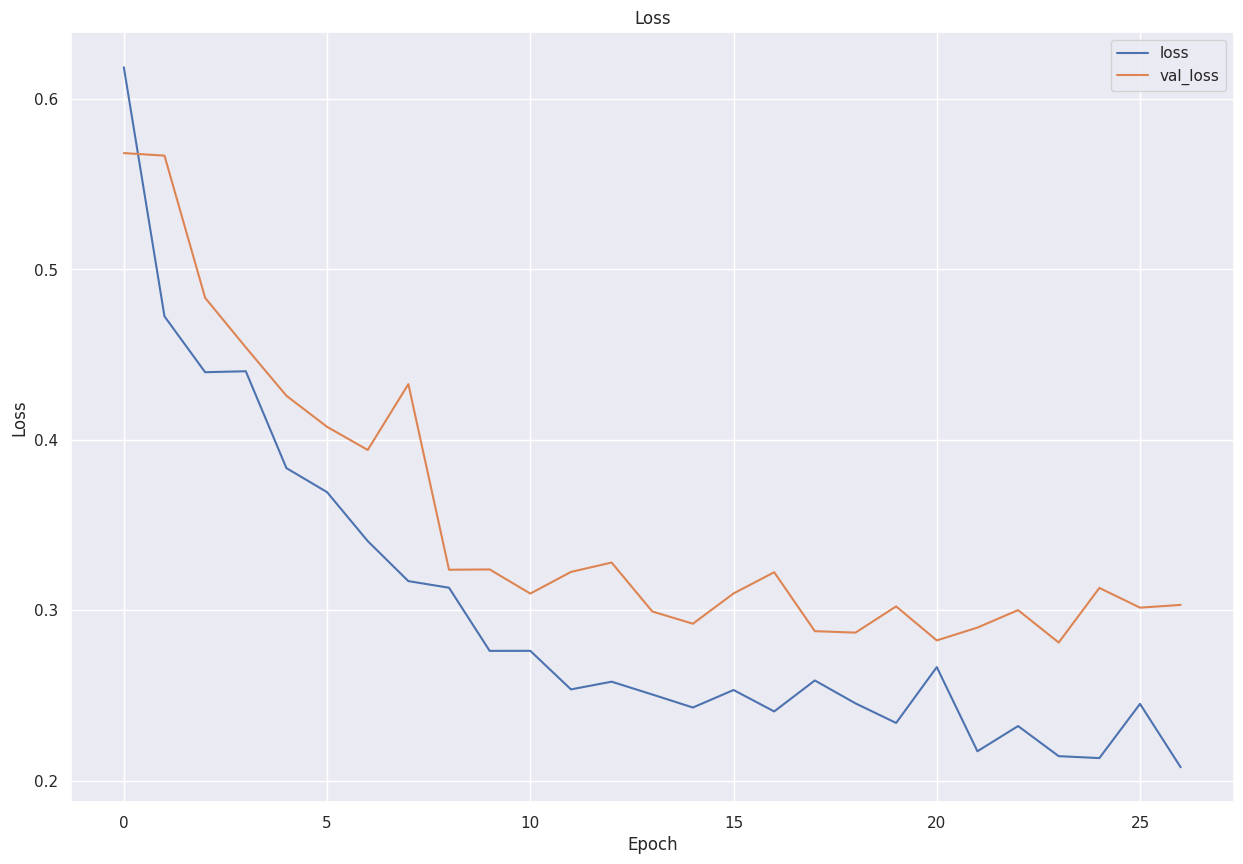

In [17]:
plt.plot(res.epoch, df.loss, label='loss')
plt.plot(res.epoch, df.val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

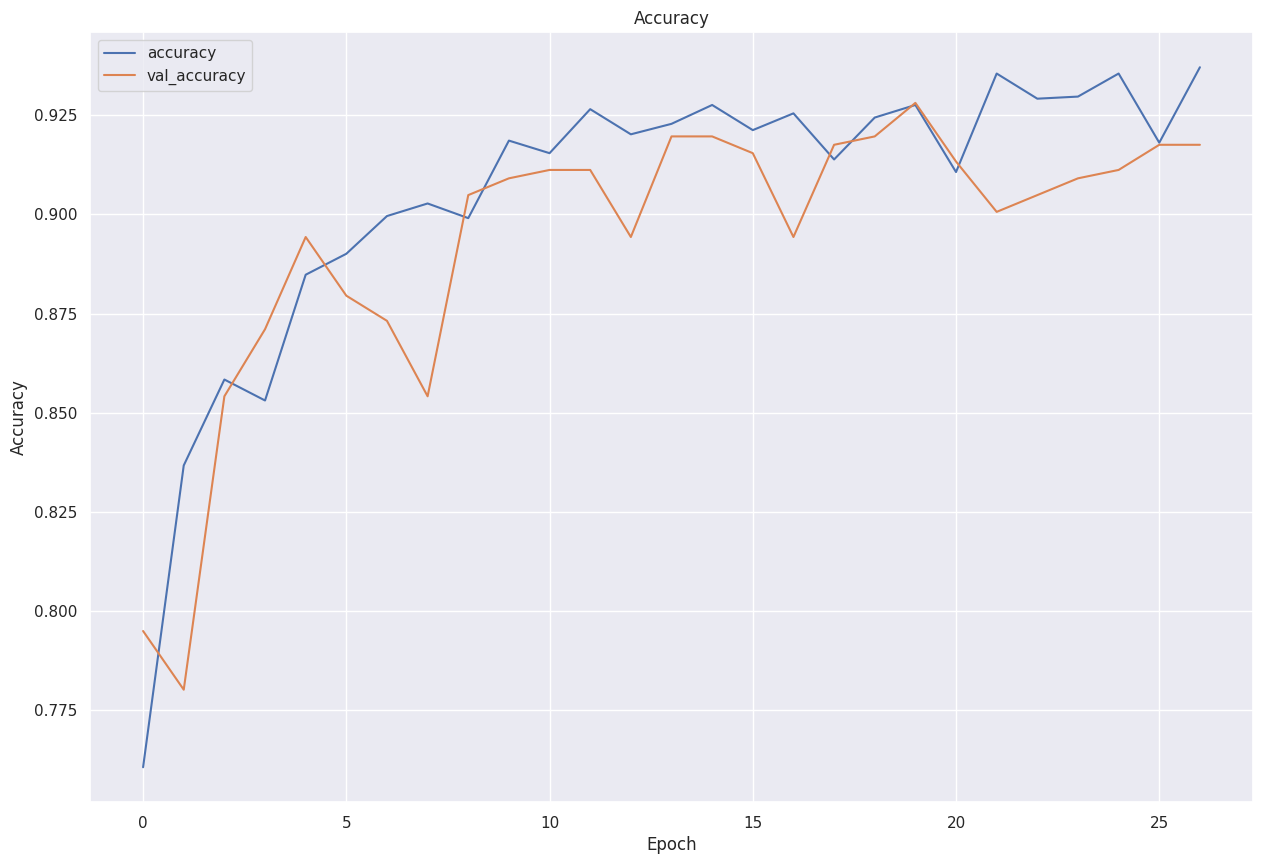

In [18]:
plt.plot(res.epoch, df.accuracy, label='accuracy')
plt.plot(res.epoch, df.val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
pred = model.predict(X_test)
pred = np.argmax(pred,1)
print('Misclassified examples: %d' % (y_test != pred).sum())

12/12 [==============================] - 0s 477us/step
Misclassified examples: 46


In [20]:
# Evaluate model
(test_loss, test_accuracy) = model.evaluate(x=X_test,y=y_test)
print("Loss:", test_loss)
print('Accuracy', test_accuracy)

12/12 [==============================] - 0s 500us/step - loss: 0.4283 - accuracy: 0.8697
Loss: 0.42828962206840515
Accuracy 0.8696883916854858


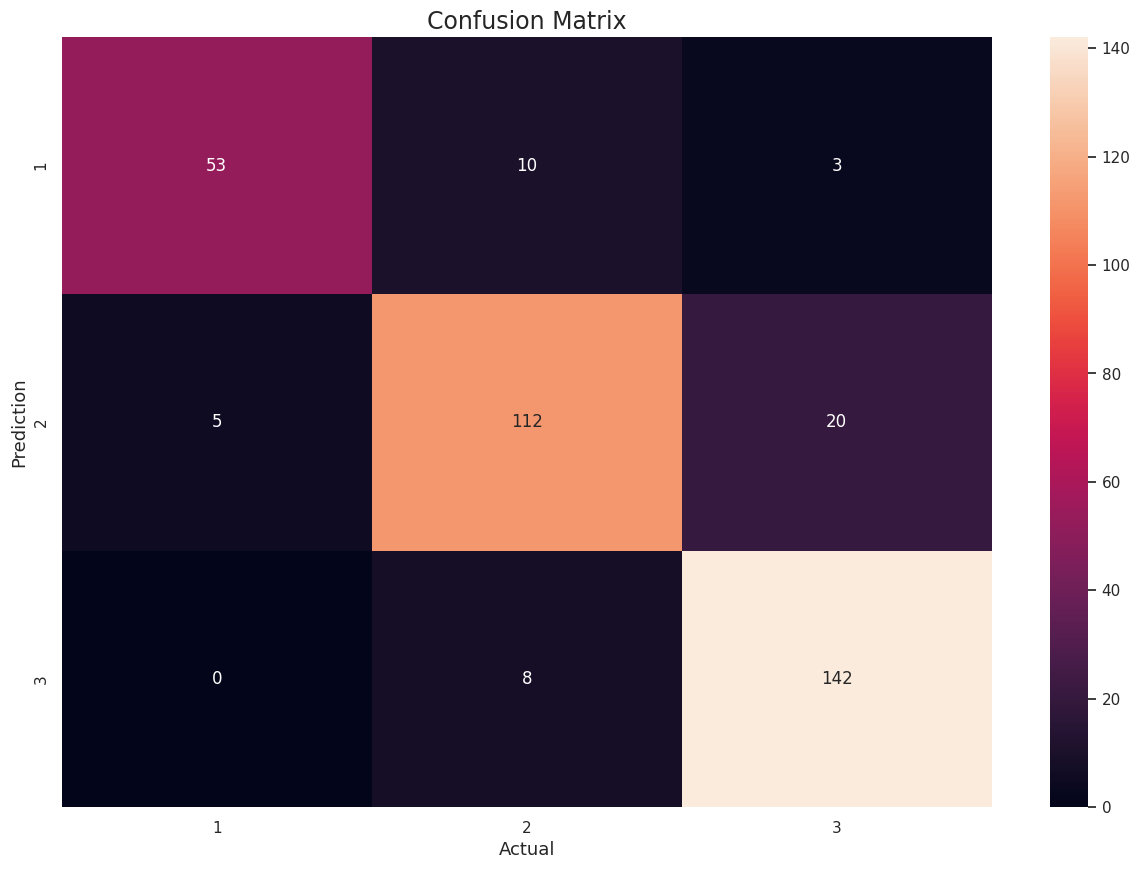

In [21]:
cm = confusion_matrix(y_test,pred)

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['1','2','3'], yticklabels=['1','2','3'])

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [116]:
# save model
path='./web/model/model.h5'
model.save(path)